In [215]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time

In [3]:
def delta_t(l):
    return -math.log(np.random.uniform())/l

## What simulations should I do later?

1. 25 different initial conditions
2. 50 runs each
3. Get metabolite / time information

## Stochastic model, no flux, no ATP

In [234]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
reaction_rates = [30, 2.637, 1.0, 0.047, 0.045, 0.022, 0.379, 0.15, 0.0098, 0.0049, 0.53, 0.733, 0.4, 0.5, 0.04, 21 ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate"]
reaction_relations = {
    0: ["Glucose"],
    1: ["G6P"],
    2: ["F6P"],
    3: ["F6P"],
    4: ["F1,6BP"],
    5: ["GADP", "DHAP"],
    6: ["DHAP"],
    7: ["GADP"],
    8: ["GADP"],
    9:["1,3BPG"],
    10:["1,3BPG"],
    11:["3PG"],
    12:["2PG"],
    13:["2PG"],
    14:["PEP"],
    15:["PEP"]
}
A = np.matrix(
    [[-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0], # GADP
    [0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0], # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]    # Pyruvate
)

initial = np.matrix(np.array([100,0,0,0,0,0,0,0,0,0,0]))

In [26]:
# reaction seven is reversible, wikipedia
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r7-1   r8     r8-1 r9   r-9   r10
reaction_rates = [30, 2.637, 1.0, 0.047, 0.045, 0.022, 0.379, 0.15, 0.0098, 0.0049, 0.53, 0.003, 0.733, 0.4, 0.5, 0.04, 21 ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate"]
reaction_relations = {
    0: ["Glucose"],
    1: ["G6P"],
    2: ["F6P"],
    3: ["F6P"],
    4: ["F1,6BP"],
    5: ["GADP", "DHAP"],
    6: ["DHAP"],
    7: ["GADP"],
    8: ["GADP"],
    9:["1,3BPG"],
    10:["1,3BPG"],
    11:["3PG"],
    12:["3PG"],
    13:["2PG"],
    14:["2PG"],
    15:["PEP"],
    16:["PEP"]
}
A = np.matrix(
    [[-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0,0], # GADP
    [0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,1,-1,-1,1,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0, 1,-1,-1,1,0,0,0], # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]    # Pyruvate
)

initial = np.matrix(np.array([100,0,0,0,0,0,0,0,0,0,0]))

In [82]:
def smart_simulate(v, A, iterations, simtime=1):
    
    times = [0]
    
    dt = [[delta_t(v[-1, j]) for j in range(11)] for i in range(iterations)]
    
    for thing in dt:
        print(thing)
    
        


In [83]:
smart_simulate(initial, A, 20)

[0.016363070363024774, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.007749614503839997, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.002992815246067791, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.0024409162828580456, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.001968246454744237, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.0007119862836549688, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.0024419479424844727, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.0019020756452703777, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.0006816535047084318, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.0022331920704557772, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.0015007847537067255, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[9.515683454720538e-05, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.002796476819819267, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]
[0.001185918720722544, inf, inf, inf, inf, 

/home/smudge/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [218]:
def simulate_reactions_basic(v, A, iterations, verbose=False):
    
    times = [0]
    
    for i in range(iterations):
        
        #get relevant reactants
        reactant_indices = [j for j, item in enumerate(np.ravel(v[-1])) if item !=0]
        cur_reactants = [reactants[j] for j in reactant_indices]
        cur_reactant_amounts = {r: v[-1,j ]for j, r in enumerate(reactants)}
        
        #compute possible next reactions
        next_reactions = [rxn for rxn, req in reaction_relations.items() if set(req).issubset(set(cur_reactants))]
        
        #exit if we have there are no possible next reactions:
        if len(next_reactions) == 0:
            break
        
        #compute rxn coefficients for possible next reactions:
        rxn_rates = {rxn: reaction_rates[rxn]*math.exp(sum(map(math.log,[v[-1,reactants.index(r)] for r in reaction_relations[rxn]]))) for rxn in next_reactions}
        
        #compute delta ts:
        dt = {rxn: delta_t(rate) for rxn, rate in rxn_rates.items()}
        
        #find fastest dt:
        next_state = min(dt, key=dt.get)
        
        #update times:
        times.append(times[-1] + dt[next_state])
        
        #update v:
        v = np.vstack((v, v[-1]+A[:,next_state].T))
        
        if verbose == True:
            print("v[-1]:", np.ravel(v[-1]))
            print("cur reactants", cur_reactants)
            print("cur_reactant_amounts", cur_reactant_amounts)
            print("next reactions", next_reactions)
            print("rxn_rates", rxn_rates)
            print("dt:", dt)
            print("fastest dt:", min(dt, key=dt.get))
            print()
        
    return times, v, i+1






In [222]:
initial = np.matrix(np.array([100,0,0,0,0,0,0,0,0,0,0]))
times, v, final_iterations = simulate_reactions_basic(initial, A,  500)


In [210]:
print(v[-5:])

[[ 0 31 62  7  0  0  0  0  0  0  0]
 [ 0 30 63  7  0  0  0  0  0  0  0]
 [ 0 31 62  7  0  0  0  0  0  0  0]
 [ 0 30 63  7  0  0  0  0  0  0  0]
 [ 0 31 62  7  0  0  0  0  0  0  0]]


In [212]:
T[-1]

4894.304833258462

time elapsed: 202.58875703811646 seconds


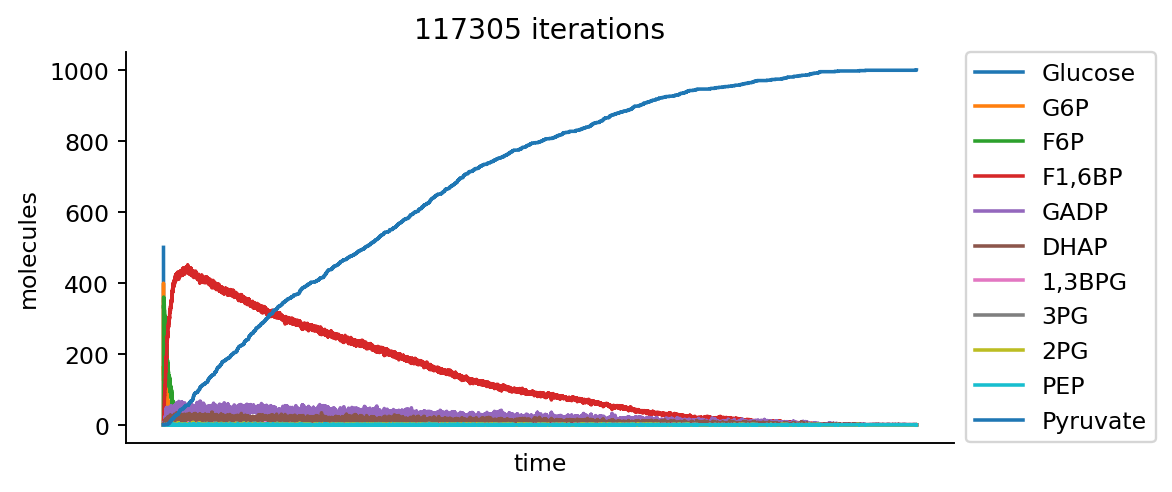

In [223]:
start_time = time.time()
iters = 200000
initial = np.matrix(np.array([500,0,0,0,0,0,0,0,0,0,0]))
fig, axes = plt.subplots(1,1,figsize=(7,3), dpi=170)

T, V, I = simulate_reactions_basic(initial, A,  iters)
for j in range(V.shape[1]):
    axes.plot(T, np.ravel(V[:,j]))
axes.set_title("{} iterations".format(I))
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_xticks([])
axes.set_xlabel("time")
axes.set_ylabel("molecules")
axes.legend(reactants, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
end_time = time.time()
print("time elapsed: {} seconds".format(end_time-start_time))

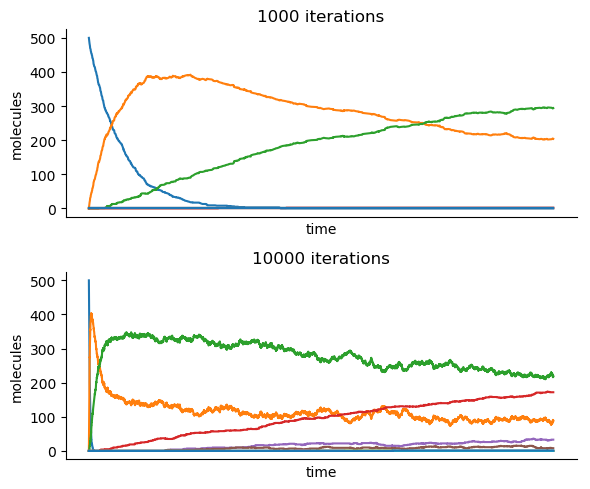

In [191]:
#initial = np.matrix(np.array([1000,2450,620,5510,810,150,5.83,520,70,80,1850]))
initial = np.matrix(np.array([500,0,0,0,0,0,0,0,0,0,0]))
#initial = np.matrix(np.array([100 for i in range(11)]))
fig, axes = plt.subplots(2,1,figsize=(6,5), dpi=100)

for i, iters in enumerate([1000, 10000]):
    T, V = simulate_reactions(initial, A,  iters)
    for j in range(V.shape[1]):
        axes[i].plot(T, np.ravel(V[:,j]))
    #axes[i].legend(["A", "B", "C"])
    axes[i].set_title("{} iterations".format(iters))
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xticks([])
    axes[i].set_xlabel("time")
    axes[i].set_ylabel("molecules")
    #axes[i].legend(reactants)
    
plt.tight_layout()

## Stochastic simulation, no flux, with ATP

In [248]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
reaction_rates = [30, 2.637, 1.0, 0.047, 0.045, 0.022, 0.379, 0.15, 0.0098, 0.0049, 0.53, 0.733, 0.4, 0.5, 0.04, 21 ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate", "ATP", "ADP"]
reaction_relations = {
    0: ["Glucose", "ATP"],
    1: ["G6P"],
    2: ["F6P"],
    3: ["F6P", "ATP"],
    4: ["F1,6BP"],
    5: ["GADP", "DHAP"],
    6: ["DHAP"],
    7: ["GADP"],
    8: ["GADP"],
    9:["1,3BPG"],
    10:["1,3BPG", "ADP"],
    11:["3PG"],
    12:["2PG"],
    13:["2PG"],
    14:["PEP"],
    15:["PEP", "ADP"]
}
A = np.matrix(
    [[-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0], # GADP
    [0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],    # Pyruvate
    [-1,0,0,-1,0,0,0,0,0,0,2,0,0,0,0,2],  # ATP
    [1,0,0,1,0,0,0,0,0,0,-2,0,0,0,0,-2]]   # ADP 
)



## Note:

We require two times as many molecules of ATP to glucose in order for the reaction to go to completion

time elapsed: 1.0842759609222412 seconds


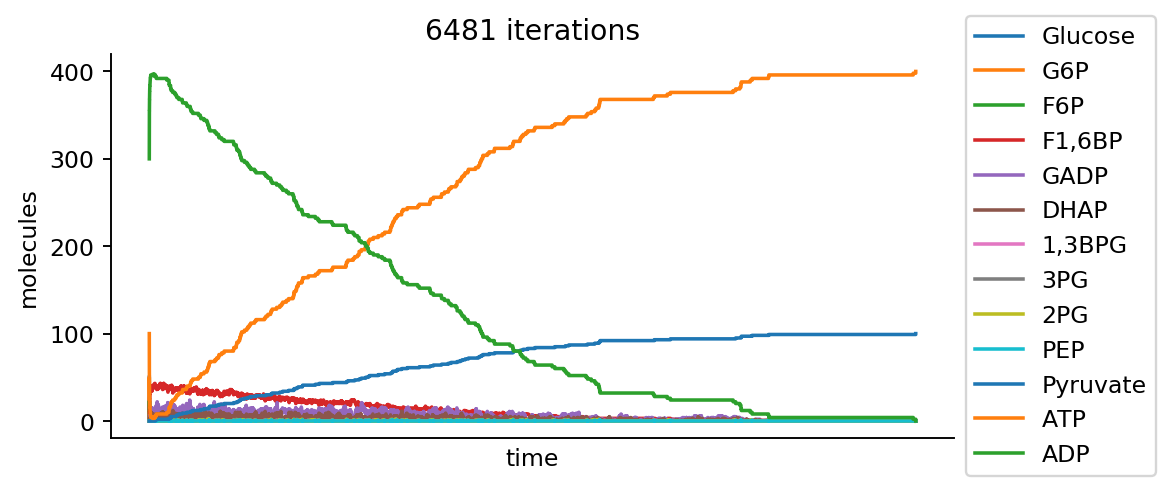

In [260]:
start_time = time.time()
iters = 10000
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0,100,300]))
#initial = np.matrix(np.array([500,0,0,0,0,0,0,0,0,0,0]))

fig, axes = plt.subplots(1,1,figsize=(7,3), dpi=170)

T, V, I = simulate_reactions_basic(initial, A,  iters)
for j in range(V.shape[1]):
    axes.plot(T, np.ravel(V[:,j]))
axes.set_title("{} iterations".format(I))
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_xticks([])
axes.set_xlabel("time")
axes.set_ylabel("molecules")
axes.legend(reactants, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
end_time = time.time()
print("time elapsed: {} seconds".format(end_time-start_time))